# Action Balance Equation Fenics Propogation Test Notebook
## $\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_y N}{\partial y} +  \frac{\partial c_\sigma N}{\partial \sigma}+ \frac{\partial c_\theta N}{\partial \theta}  = \frac{S(\sigma, \theta, t)}{\sigma}$


## Propogation Test Case:
Set source to 0, and also consider N only as function in space.

Harmonic wave propogating across 2D domain, c is constant in x and y:

$\frac{\partial N}{\partial t} +  \textbf{c} \cdot \nabla N = 0$

$\Omega = [0,10] \times [0,10]$

$\textbf{c} = (1 , 1)$

$N_0 = sin(2 \pi x) + cos (2 \pi y)$

$N_{analytic} = sin(2\pi(x - c_xt)) + cos(2 \pi (y - c_yt))$

$N = N_{analytic}$  on $\partial \Omega$

Total time = 5

number of time steps = 1000

## Weak Forms:

### Discontinuous Galerkin

### Least Squares

### SUPG

### Maybe DPG


In [1]:
#import any necessary libraries in this block
from __future__ import print_function
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#define global variables
g=9.81

In [2]:
#auxillary functions (only necessary when using source terms)



#function to calculate wavenumber from a given set of rel. radian frequencies
#formulation borrowed from Jessica and Hol. pg 123-127
#reads in a numpy array/vector of frequencies, depth (single value here since only doing 2d) 
#returns same size array of wavenumber

def calc_k(sigma,depth):
    #Use the Fenton approximation (Hol. p 124)
    alpha = sigma**2*depth/g
    beta = alpha*(np.tanh(alpha)**(-0.5))
    k = (alpha + beta**2*(np.cosh(beta))**(-2))/(depth*(np.tanh(beta) + beta*np.cosh(beta)**(-2)))
    return k

#function that calculates the group velocity
#maybe needs to be a fenics function, not sure yet, k would need to be fenics function as well
#inputs wavenumber of each node, depth (scalar since only 1 point in space), current(only vector of size 2)
#returns just cg as vector
def calc_cg(k,depth):
    #from Hol. p127
    n = 0.5*(1+(2*k*depth)/(np.sinh(2*k*depth)))
    c = np.sqrt(g/k*np.tanh(k*depth))
    return n*c

#function that calculates the propogation velocity in theta and sigma space
#ask Jessica maybe about how she approximates derivatives

    

In [3]:
#For now only dirichlet boundary conditions
def boundary(x, on_boundary):
    return on_boundary

#function that generates the weak form

def gen_weakform(mesh,WeakForm,TimeStep,V,u_D,p_degree=4):
    #Inputs:
    #mesh is the domain
    #WeakForm is string representing the variational formulation
    #V is solution space that should be chosen
    #u_D are dirichlet boundary conditions as an expression
    #p_degree is the degree expressions will be approximated to
    
    #Outputs:
    #entire weak form as F
    #boundary condition as bc
    #initial condition as u_n (necessary for time stepping)
    
    #Define source term, boundary, and wave propogation depending on test case choice
    u = TrialFunction(V)
    v = TestFunction(V)



    if WeakForm == 'Galerkin':
        bc = DirichletBC(V, u_D, boundary,"geometric")
    else:
        bc = DirichletBC(V, u_D, boundary)
    # Define initial value
    u_n = interpolate(u_D, V)
    #u_n = project(u_D, V)
    
    #Define source
    S = Constant(0)

    if WeakForm == 'LSQ':
        #Least Squares bilinear form
        #(Au, Av) = (f, Av) <==> (Au-f,Av) = 0
    
        if TimeStep == 'Implicit_Euler':
            #Implicit Euler
            F=(inner(u + dt*nabla_div(c*u) - u_n - dt*S, v + dt*nabla_div(c*v) ))*dx
        elif TimeStep == 'Trap_Rule':
            #Trap Rule
            F = (inner(u + 0.5*dt*nabla_div(c*u) + 0.5*dt*nabla_div(c*u_n) - u_n - dt*S, v + 0.5*dt*nabla_div(c*v) ))*dx
        elif TimeStep == 'Explicit_Euler':
            #Explicit Euler
            F = (inner(u+dt*nabla_div(c*u_n) - u_n - dt*S, v))*dx

    elif WeakForm == 'Galerkin':
        #continuous galerkin bilinearr form
        if TimeStep == 'Implicit_Euler':
            n=FacetNormal(mesh)
            cn=(dot(c,n) + abs(dot(c,n)))/2
            #F= inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner(cn('+')*u('+')-cn('-')*u('-'),jump(v))*dS + dt*inner(u*cn,v)*ds
            F = inner(u - dt*S - u_n,v)*dx - dt*inner(c*u,grad(v))*dx + dt*inner( cn('+')*u('+') - cn('-')*u('-'), jump(v) )*dS + dt*inner( u*dot(c,n), v )*ds
    elif WeakForm == 'SUPG':
        if TimeStep == 'Implicit_Euler':
            hmax=mesh.hmax()
            #h=Constant(5)
            tau=Expression('pow(sqrt(yn*yn+ym*ym)/hh,-1)', degree=p_degree ,  domain=mesh, yn=c_sigma , ym=c_theta , hh=hmax)
            F = inner(u - dt*S -u_n,v)*dx - dt*(inner(c*u,grad(v)))*dx + inner(u+dt*nabla_div(c*u) \
            - dt*S - u_n, tau*nabla_div(c*v))*dx
    return F,bc,u_n


#runsim function, runs a simulation given a number of timesteps, timestep size and weak form
#returns l2 error as time series as well as l-infinity error and option to plot crosssection evry n steps
def run_sim(num_steps,dt,F,u_D,bc,u_n,V,mesh,plot_every=0):
    #splits lhs and rhs of weak form
    a, L = lhs(F), rhs(F)

    # establishes solution variable
    u = Function(V)

    #initializes variables for time loop
    t = 0
    #things for storing error
    l2_err_vec=np.zeros(num_steps)
    error = np.zeros(num_steps)
    error_ind = np.zeros(num_steps)
    node_num = mesh.num_vertices()
    node_xy = mesh.coordinates()
    spacing=nx+1
    x=np.linspace(0,1,spacing)
    level=int(spacing/2)

    for n in range(num_steps):
        #advance time
        t+=dt
        u_D.t = t
        #compute solution at new timestep
        # Compute solution
        solve(a == L, u, bc)
        #update solution
        u_n.assign(u)
        # Compute exact solution at vertices|
        u_e = interpolate(u_D, V)
        #L2 error
        e0=u-u_e
        L2r = assemble(inner(e0,e0)*dx)
        L2e = sqrt(L2r)
        L2_u = assemble(inner(u,u)*dx)
        L2_exact = assemble(inner(u_e,u_e)*dx)
        l2_err_vec[n]=L2e
    
    
    
        #u_exac_vec=u_e.vector().array()
        #u_vec=u.vector().array()
        u_vec=u.compute_vertex_values()
        u_exac_vec=u_e.compute_vertex_values()
        #L infinity error
        error[n] = np.abs(u_exac_vec-u_vec).max()
        error_ind[n]= np.argmax(np.abs(u_exac_vec-u_vec))
        #sol0=u
    
    
    
        if plot_every != 0:
            if (n+plot_every)%plot_every==0:
                # Plot solution
                plt.plot(x,u_exac_vec[spacing*level:spacing*(level+1)],label='exact')
                plt.plot(x,u_vec[spacing*level:spacing*(level+1)],label='FEM')
                plt.plot(x,np.abs(u_exac_vec-u_vec)[spacing*level:spacing*(level+1)],label='error')
                plt.legend()
                plt.xlim=([0, 1])
                plt.ylim=([-1, 1])
                plt.show()
                print('t = %.3f: error = %.3g' % (t, error[n]))
                print('error max located at ',str(node_xy[int(error_ind[n])]))
    
    #returns l-infinity error then l2 error at each time step
    return error,l2_err_vec,u
    
#also a function to take dof to a meshgrid for plotting
def dof_2_meshgrid_indeces(dofs):
    #takes in list of degrees of freedom, outputs list of array coordinates
    #each dof corresponds to in meshgrid
    num_col=len(np.unique(dofs[:,0]))
    num_row=len(np.unique(dofs[:,1]))
    #print(num_row)
    #print(num_col)
    Matrix_indeces=np.zeros(dofs.shape)
    new_indeces=np.argsort(dofs[:,0])
    #create input to save
    input_array=np.zeros(new_indeces.shape)
    dum=0
    for a in range(len(input_array)):
        input_array[a]=dum
        if (a+1)%num_row==0:
            dum=int(dum+1)
    #set indeces for columns
    Matrix_indeces[new_indeces,1]=input_array
    
    #now do same for row numbers
    new_indeces=np.argsort(dofs[:,1])
    dum=0
    for a in range(len(input_array)):
        input_array[a]=dum
        if (a+1)%num_col==0:
            dum=int(dum+1)
    Matrix_indeces[new_indeces,0]=input_array
    return Matrix_indeces

#lastly take a set of matrix indeces and create a matrix
def indeces_to_meshgrid(dof,Matrix_indeces):
    #allocate output array
    num_row=np.amax(Matrix_indeces[:,0])+1
    num_col=np.amax(Matrix_indeces[:,1])+1
    out_array=np.zeros((int(num_row),int(num_col)))
    
    ctr=0
    for a in dof:
        out_array[int(Matrix_indeces[ctr,0]),int(Matrix_indeces[ctr,1])]=a
        ctr=ctr+1
    return out_array

#turn a meshgrid matrix back to a dof vector given the Matrix_indeces
def meshgrid_to_dof(array_shape,Matrix_indeces):
    #expects 2d array
    out_len=(array_shape.shape[0]*array_shape.shape[1])
    dof_out=np.zeros(out_len)
    for a in range(out_len):
        dof_out[a]=array_shape[int(Matrix_indeces[a,0]),int(Matrix_indeces[a,1])]
    return dof_out


Time step is 0.005



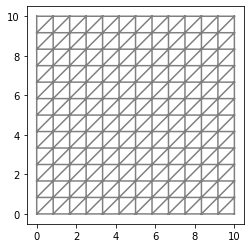

CFL condition number is  0.012


In [4]:
#Specify here specifically what simulation should be tested

T = 5          # Total duration of time
num_steps = 1000     # number of time steps
dt = T / num_steps  # time step size
print('Time step is '+str(dt) + '\n')
nx = ny = 12        #defines number of cells in each direction
p_degree = 1      #defines degree to approximate any expression
L = 10 #size of domain

#create mesh and plot mesh
mesh = RectangleMesh(Point(0.0,0.0),Point(L,L),nx, ny)
plot(mesh)
plt.show()


c_sigma = 1         #  propogation speed
c_theta = 1
c = Constant((c_sigma,c_theta))
    
#define boundary condition(exact solution as well in this case)
u_D = Expression('sin((x[0]-c[0]*t))+cos((x[1]-c[1]*t))',
                 degree=4, c=c, t=0,domain=mesh)



print('CFL condition number is ', str(c_sigma*dt*(nx/L) + c_theta*dt*(ny/L)))


In [5]:
#Input list of weak forms to test
#Options are LSQ, Galerkin (DG), SUPG
Weak_Tests=['SUPG']#,'Galerkin','SUPG']
#Weak_Tests=['SUPG']
#Input list of time step options 'Implicit Euler', length must agree with weakform length
TimeSteps=['Implicit_Euler']#, 'Implicit_Euler', 'Implicit_Euler']
#TimeSteps=['Implicit_Euler']
#select degree/type of basis function (Galerkin must be DG)
p_types = ['P']#,'DG','CG']
#p_types=['P']
pq_degree = [1]#,1,1]
#pq_degree=[2]
#select time step (type a string either Implicit_Euler, Explicit_Euler, or Trap_Rule)
#create basis functions


# Define variational spaces


error=np.zeros((num_steps,len(Weak_Tests)))
l2_err_vec=np.zeros((num_steps,len(Weak_Tests)))
#need to define it each time if you run due to some kind of scope issue

a=0
for WeakForm in Weak_Tests:

    u_D.t=0
    V = FunctionSpace(mesh, p_types[a] , pq_degree[a])
    #build weakform
    F,bc,u_n=gen_weakform(mesh,WeakForm,TimeSteps[a],V,u_D,p_degree=4)

    #run simulation

    error[:,a],l2_err_vec[:,a],u=run_sim(num_steps,dt,F,u_D,bc,u_n,V,mesh,plot_every=0)
    a=a+1


1.95892427466


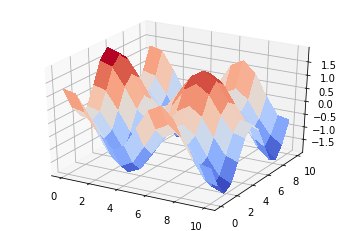

In [6]:
#plot last time step of last simulation
u_D.t=num_steps*dt
u_e=u_D
u_e=interpolate(u_e,V)
#Out_vec=u_e.vector()[:]#exact
Out_vec=u.vector()[:] #simulation

#get mesh coordinates
n=V.dim()
d=mesh.geometry().dim()
dof_coordinates=np.zeros((n,d))
dof_x=np.array(interpolate(Expression('x[0]',degree=1),V).vector())
dof_y=np.array(interpolate(Expression('x[1]',degree=1),V).vector())
dof_coordinates[:,0]=dof_x
dof_coordinates[:,1]=dof_y

Matrix_indeces=dof_2_meshgrid_indeces(dof_coordinates)
X=indeces_to_meshgrid(dof_x,Matrix_indeces)
Y=indeces_to_meshgrid(dof_y,Matrix_indeces)
Plot_out=indeces_to_meshgrid(Out_vec,Matrix_indeces)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Plot_out, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
print(np.amax(Plot_out))

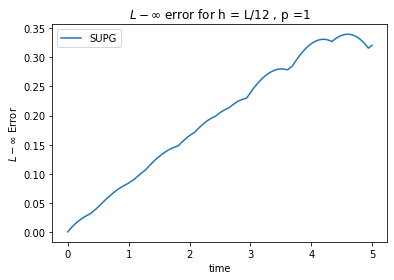

Text(0, 0.5, 'L-2 error')

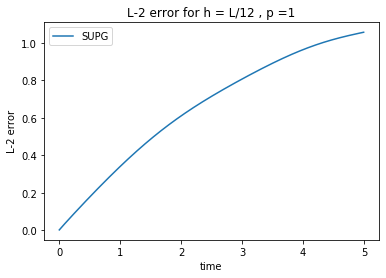

In [7]:
#post-processing in this block


plt.plot(np.array(range(num_steps))*dt,error)
plt.legend(Weak_Tests)
plt.title('$L-\infty$ error for h = L/'+ str(nx)+" , p ="+str(pq_degree[0]) )
plt.xlabel('time')
plt.ylabel('$L-\infty$ Error')
#plt.savefig("l_infty_error_propogation_test_h_L_"+str(nx)+"p_"+str(pq_degree[0])+".png")
plt.show()
plt.plot(np.array(range(num_steps))*dt,l2_err_vec)
plt.legend(Weak_Tests)
plt.title('L-2 error for h = L/'+ str(nx) +" , p ="+str(pq_degree[0]))
plt.xlabel('time')
plt.ylabel('L-2 error')
#plt.savefig("l_2_error_propogation_test_h_L_"+str(nx)+"p_"+str(pq_degree[0])+".png")
# Hold plot
#interactive()

In [8]:
print('Initial L-inf error')
print(error[0,:])
print('Final L-inf error')
print(error[-1,:])
print('Max L-inf error')
print(np.amax(error,axis=0))
print('Initial L-2 error')
print(l2_err_vec[0,:])
print('Final L-2 error')
print(l2_err_vec[-1,:])
print('Max L-2 error')
print(np.amax(l2_err_vec,axis=0))

Initial L-inf error
[ 0.00064615]
Final L-inf error
[ 0.32032739]
Max L-inf error
[ 0.33924379]
Initial L-2 error
[ 0.00188764]
Final L-2 error
[ 1.05623416]
Max L-2 error
[ 1.05623416]
